In [1]:
import os
import sys
sys.path.append('..')
import torch

import pretorched.visualizers as vutils
from pretorched.models import utils as mutils
import core
from data import VideoFolder, transforms

%load_ext autoreload
%autoreload 2

In [2]:
device = 'cpu' if torch.cuda.is_available() else 'cpu'

In [3]:
data_root = os.environ.get('DATA_ROOT', '')
part_dir = os.path.join(data_root, 'DeepfakeDetection', 'facenet_videos', 'dfdc_train_part_0')
videos = os.listdir(part_dir)

In [4]:
datadir = os.path.join(part_dir, videos[1])
dataset = VideoFolder(datadir, step=6, transform=transforms.get_transform(split='val', normalize=False, rescale=False))
print(dataset)

Dataset VideoFolder
  Root dir: /data/datasets/DeepfakeDetection/facenet_videos/dfdc_train_part_0/bqefygjsnx.mp4
  Number of datapoints: 2
  Transforms (if any): Compose(
                           Compose(
                           ResizeVideo(size=256, interpolation=PIL.Image.BILINEAR)
                           CenterCropVideo(size=(224, 224))
                       )
                           CollectFrames()
                           PILVideoToTensor(rescale=False, ordering='CTHW')
                           IdentityTransform()
                       )



In [5]:
name, frames, target = dataset[0]
frames = frames.unsqueeze(0)
print(frames.min(), frames.mean(), frames.max())

tensor(0.) tensor(86.5176) tensor(254.)


In [6]:
model = core.get_model('SeriesPretrainedFrozenSmallManipulatorAttnDetector')
# ckpt_file = os.path.join('best_weights', 'SeriesPretrainedFrozenSmallManipulatorDetector_resnet18_all_TSNFrameSampler_seg_count-8_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-60_best.pth.tar')

# ckpt = torch.load(ckpt_file, map_location='cpu')
# state_dict = mutils.remove_prefix(ckpt['state_dict'])
# model.load_state_dict(state_dict)
model = model.to(device)
model.eval()
# print()


Switching basemodel to samxresnet18...


SeriesManipulatorAttnDetector(
  (manipulator_model): MagNet(
    (encoder): Encoder(
      (pad1): ReflectionPad2d((3, 3, 3, 3))
      (conv1): Conv2d(3, 16, kernel_size=(7, 7), stride=(1, 1), bias=False)
      (pad2): ReflectionPad2d((1, 1, 1, 1))
      (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (resblks): Sequential(
        (0): ResBlock(
          (pad1): ReflectionPad2d((1, 1, 1, 1))
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (pad2): ReflectionPad2d((1, 1, 1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (relu): ReLU(inplace=True)
        )
        (1): ResBlock(
          (pad1): ReflectionPad2d((1, 1, 1, 1))
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (pad2): ReflectionPad2d((1, 1, 1, 1))
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
          (relu): ReLU(inplace=True

## Original Frames

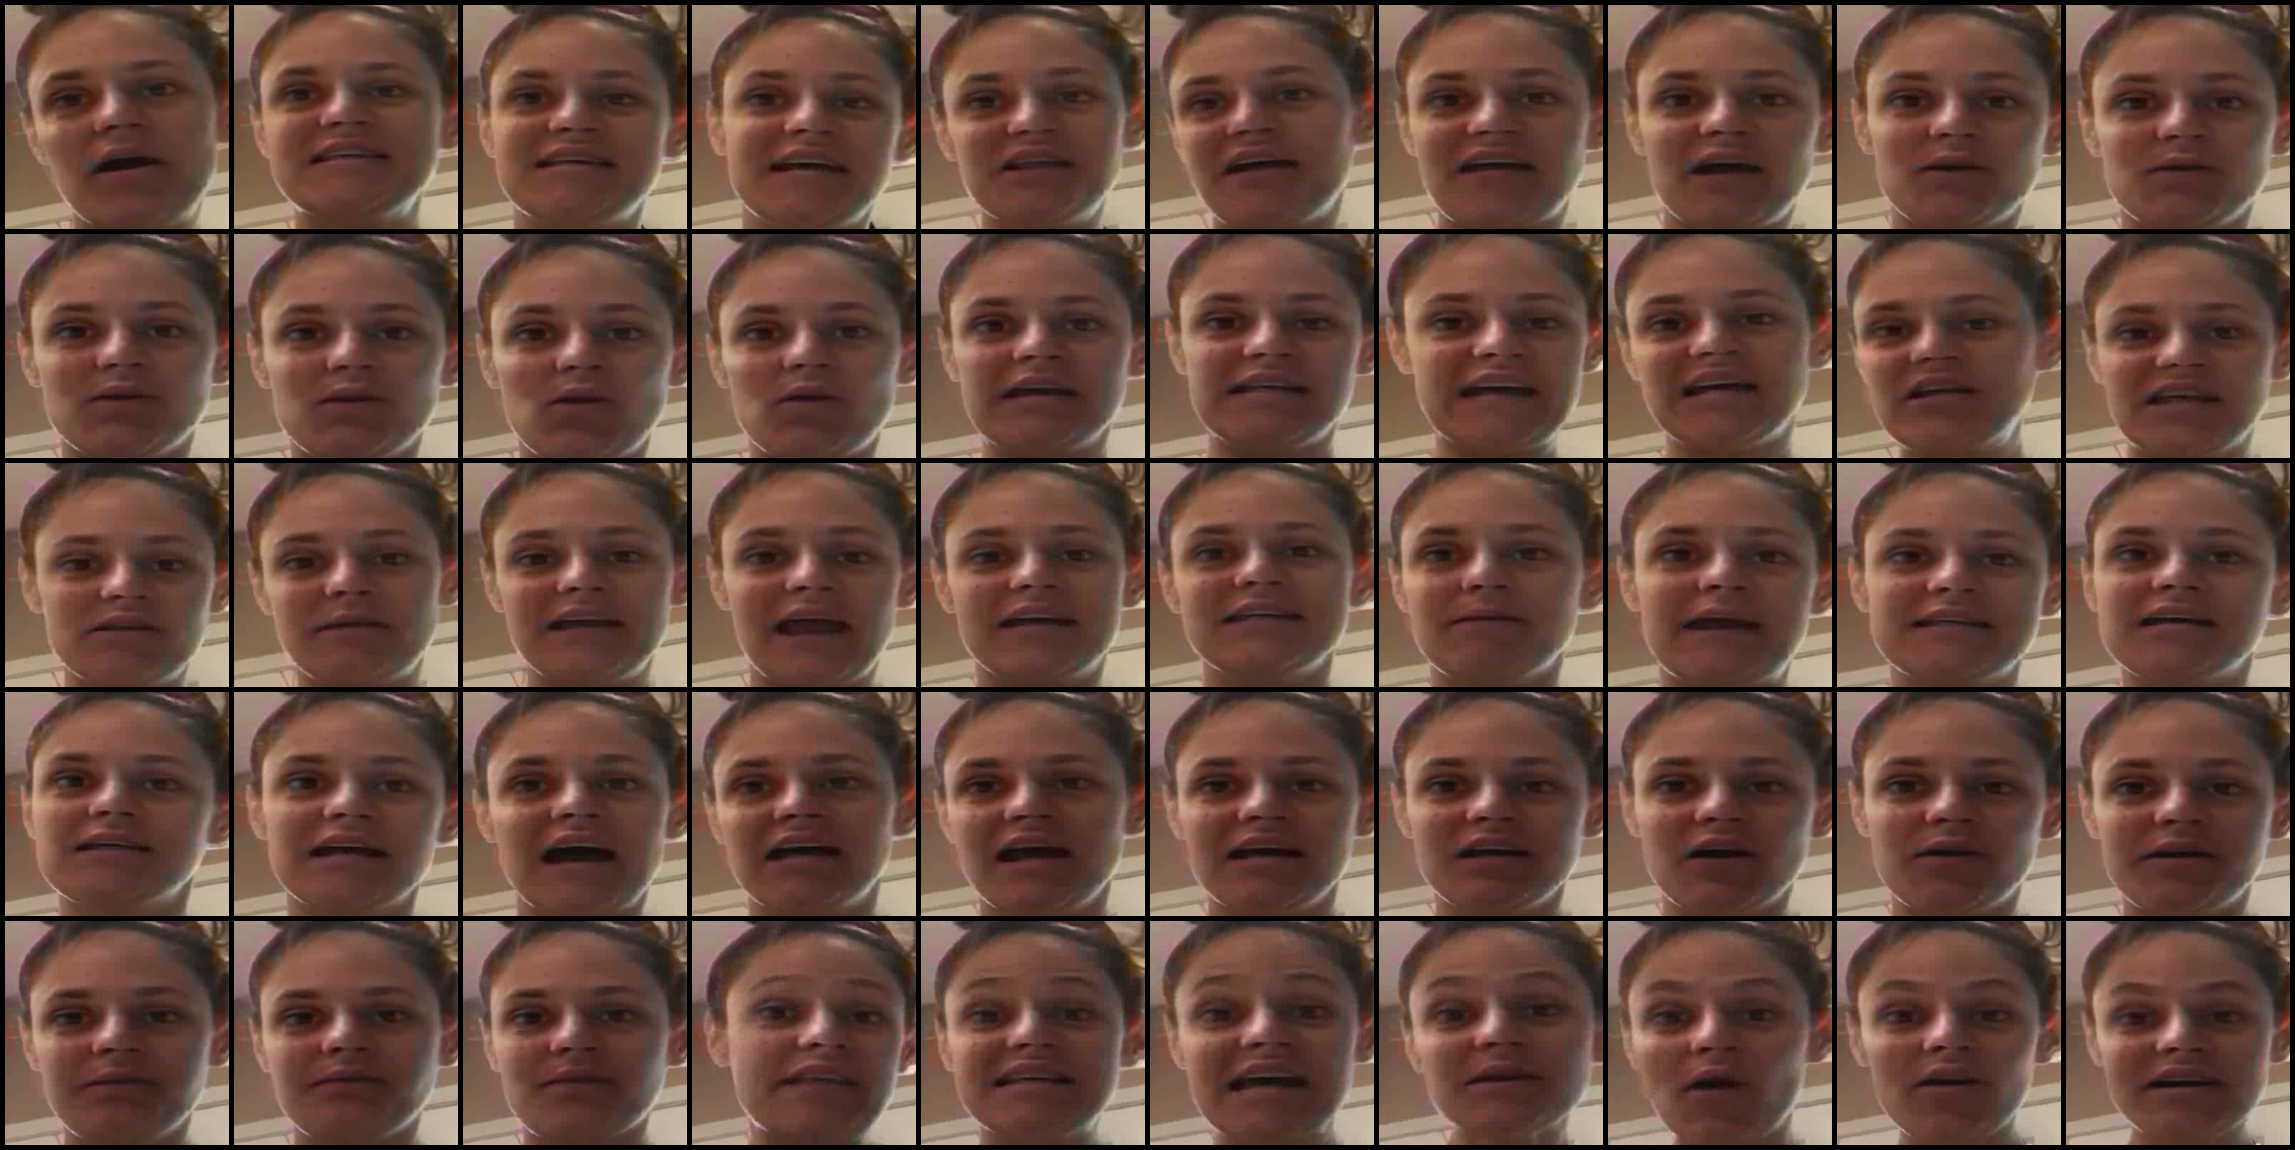

In [7]:
vutils.visualize_samples(frames.squeeze(0).transpose(0, 1), nrow=10)

## Manipulated Frames (No Attention)

In [8]:
with torch.no_grad():
    frames = frames.to(device)
    out = model.manipulator_model.manipulate_video(frames, amp=5)

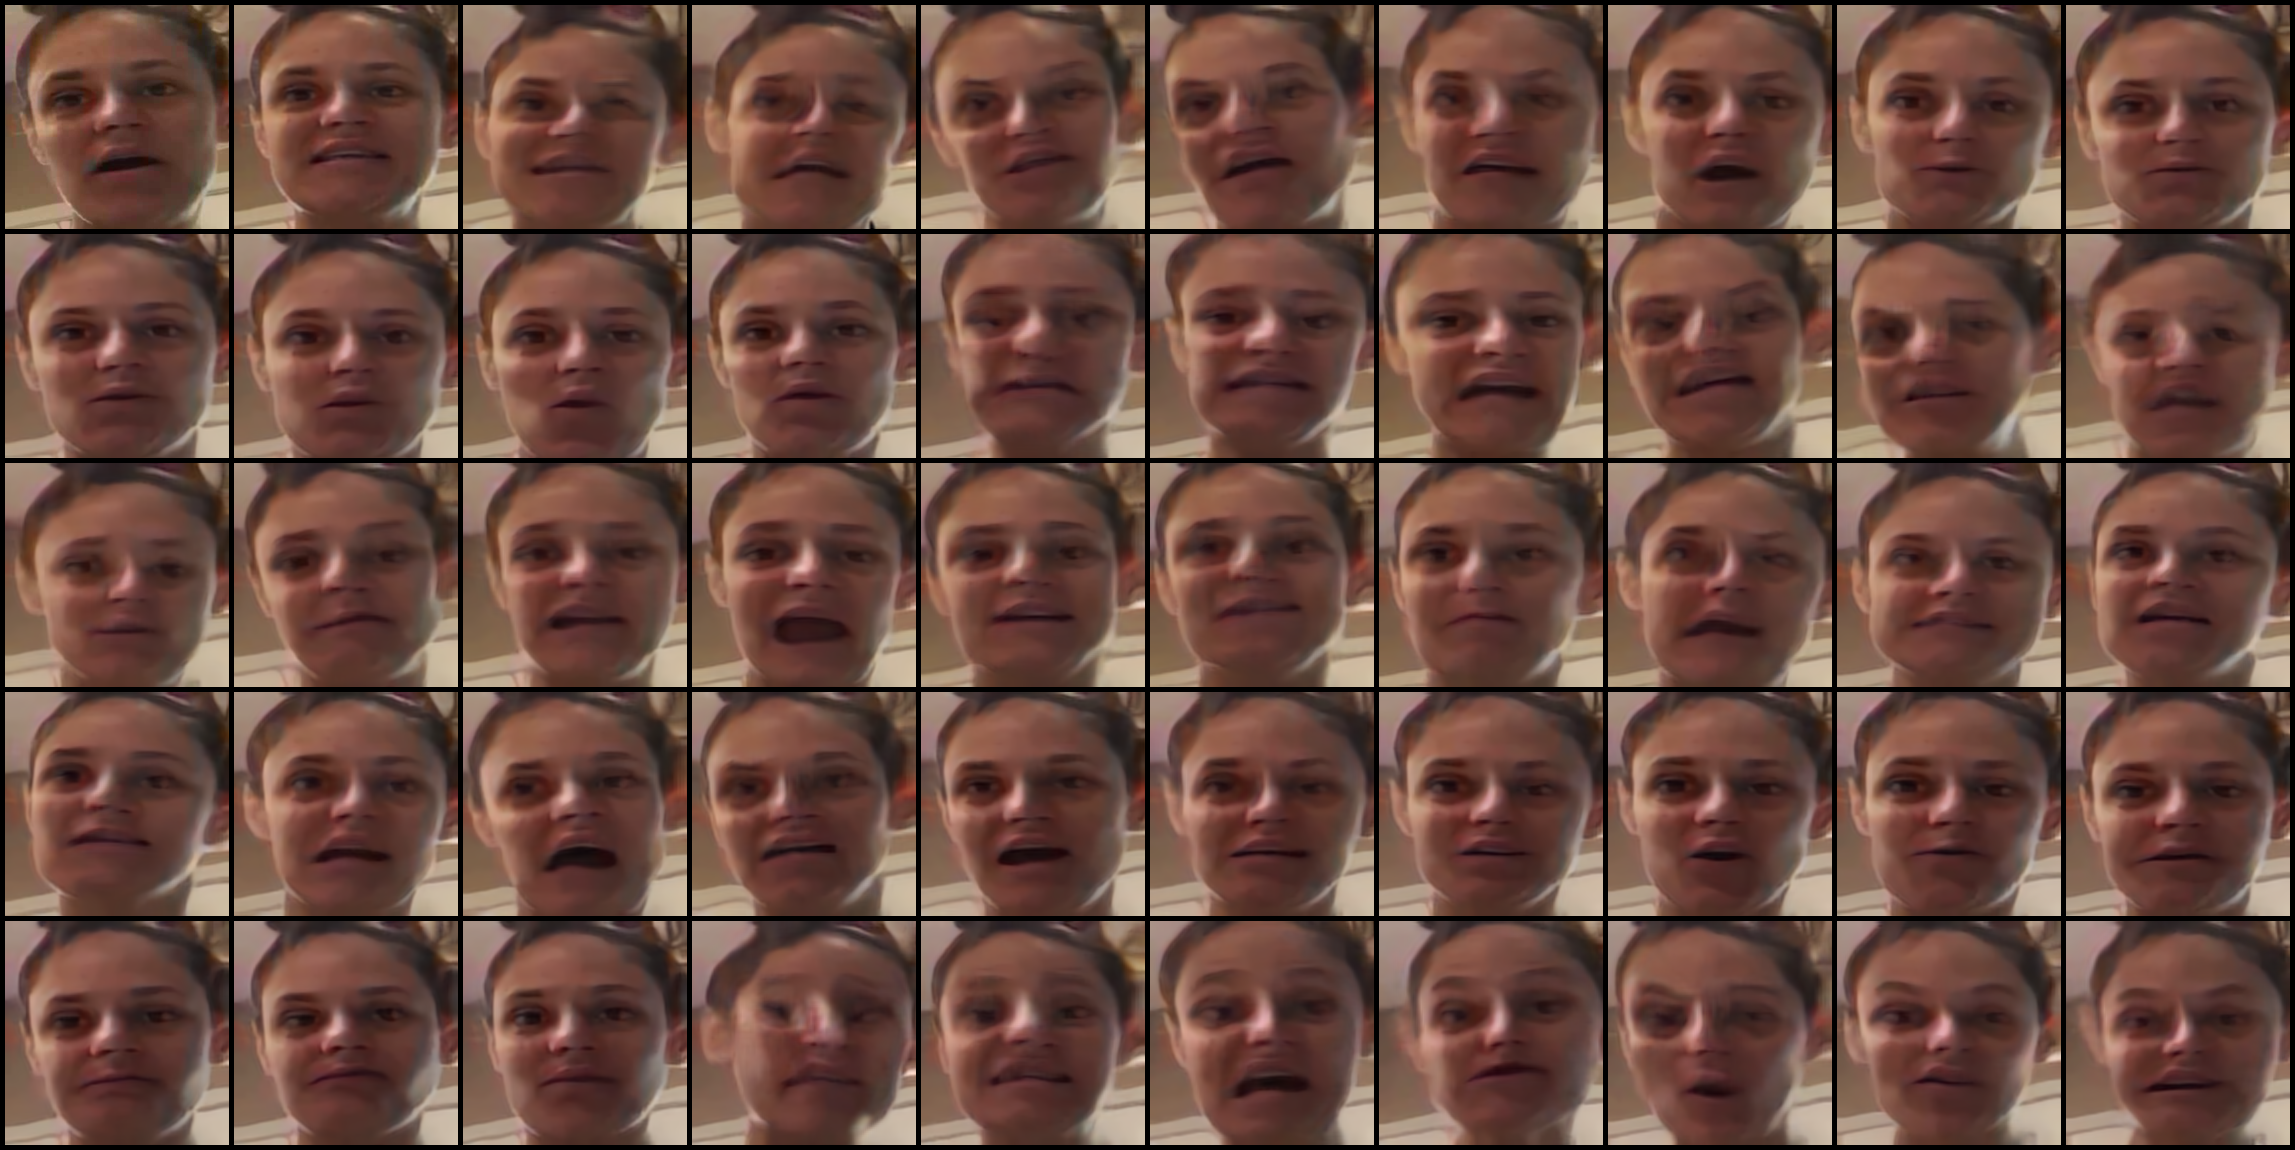

In [9]:
vutils.visualize_samples(out.squeeze(0).transpose(0, 1), nrow=10)

## Manipulated Frames (with untrained artifact attn)

In [23]:
with torch.no_grad():
    frames = frames.to(device)
    out, attn_map = model.detector_model(frames)
#     o = model.manipulate(frames, amp=model.amp_param, attn_map=attn_map)
    o = model.manipulate(frames, amp=10, attn_map=attn_map)
#     out = model.manipulator_model.manipulate_video(frames, amp=5)

In [24]:
print(frames.min(), frames.mean(), frames.max())
print(model.amp_param)

tensor(0.) tensor(86.5176) tensor(254.)
Parameter containing:
tensor([[[[4.]]]], requires_grad=True)


In [25]:
print(attn_map.shape)

torch.Size([1, 50, 56, 56])


In [26]:
print(attn_map.min(), attn_map.mean(), attn_map.max())

tensor(0.2446) tensor(0.3574) tensor(0.4180)


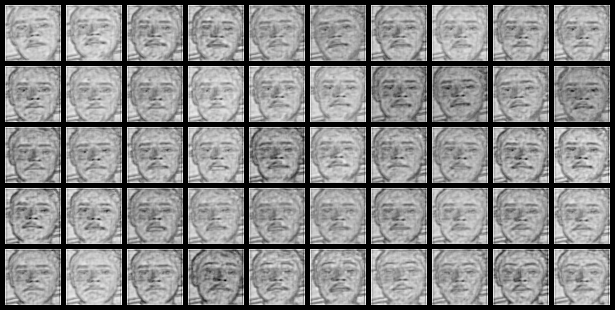

In [27]:
vutils.visualize_samples(attn_map.transpose(0, 1), nrow=10)

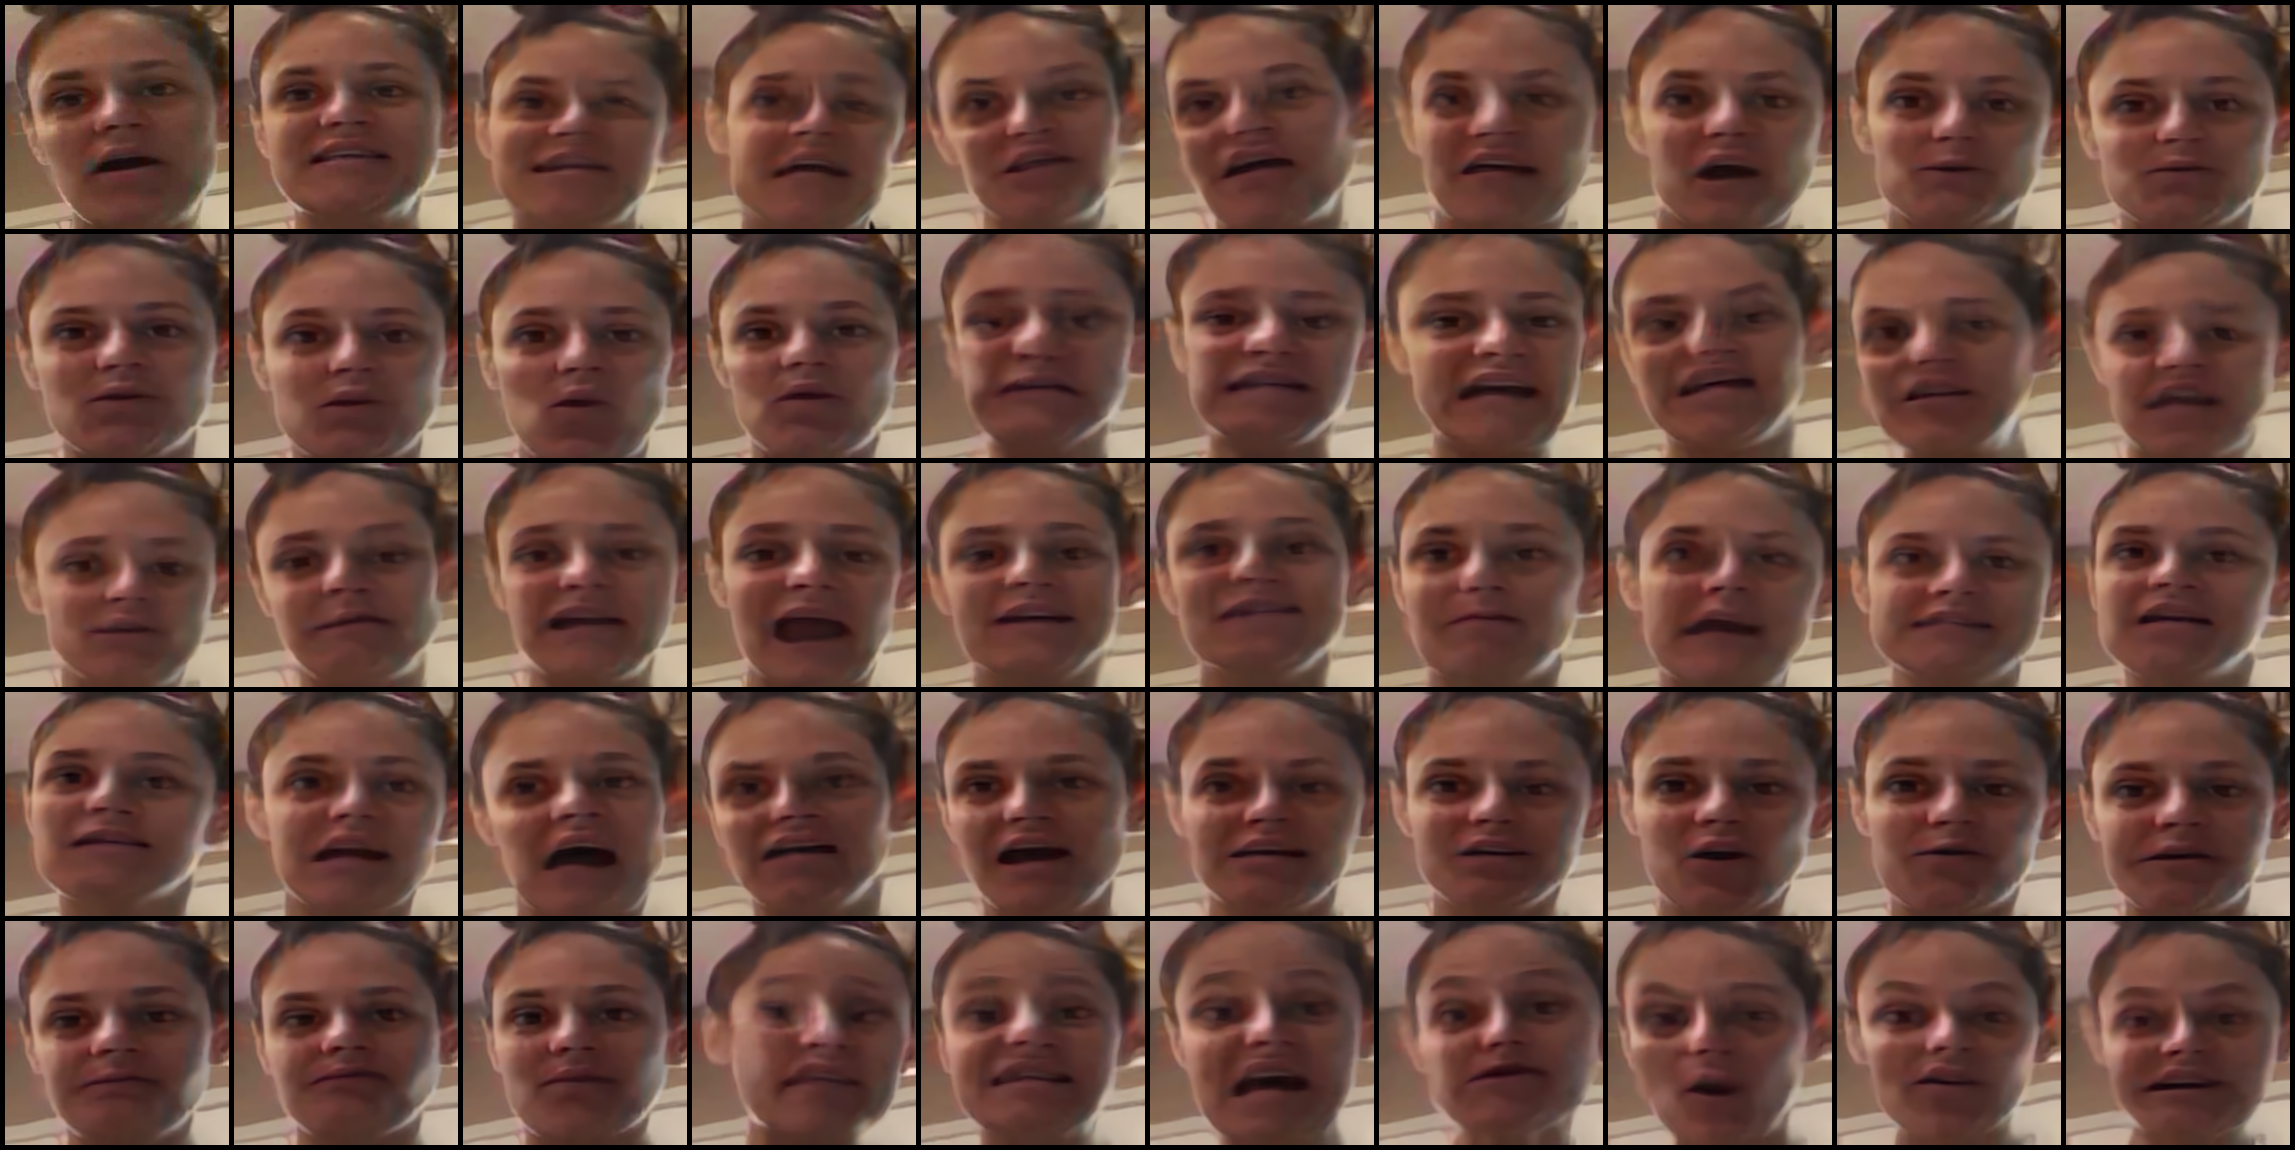

In [28]:
vutils.visualize_samples(o.squeeze(0).transpose(0, 1), nrow=10)

In [16]:
# model = core.get_model('SeriesPretrainedSmallManipulatorDetector')
# ckpt_file = os.path.join('weights', 'SeriesPretrainedSmallManipulatorDetector_resnet18_all_TSNFrameSampler_seg_count-8_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-60_best.pth.tar')


# ckpt = torch.load(ckpt_file, map_location='cpu')
# state_dict = mutils.remove_prefix(ckpt['state_dict'])
# model.load_state_dict(state_dict)
# model = model.to(device)
# model.eval()
# print()

In [17]:
# with torch.no_grad():
#     frames = frames.to(device)
#     out = model.manipulate(frames, amp=4)

In [18]:
# vutils.visualize_samples(out.squeeze(0).transpose(0, 1), nrow=5)

In [19]:
# model = core.get_model('SeriesPretrainedFrozenMediumManipulatorDetector')
# ckpt_file = os.path.join('weights', 'SeriesPretrainedFrozenMediumManipulatorDetector_resnet18_all_TSNFrameSampler_seg_count-16_init-imagenet-ortho_optim-Ranger_lr-0.001_sched-CosineAnnealingLR_bs-36_best.pth.tar')


# ckpt = torch.load(ckpt_file, map_location='cpu')
# state_dict = mutils.remove_prefix(ckpt['state_dict'])
# model.load_state_dict(state_dict)
# model = model.to(device)
# model.eval()
# print()

In [20]:
#  with torch.no_grad():
#     frames = frames.to(device)
#     out = model.manipulate(frames, amp=4)

In [21]:
# vutils.visualize_samples(out.squeeze(0).transpose(0, 1), nrow=5)